In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


In [ ]:
df=pd.read_csv('seattle-weather.csv')

In [ ]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [ ]:
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["month"] = df["date"].dt.month
df["dayofyear"] = df["date"].dt.dayofyear

In [ ]:
null_columns = df.columns[df.isnull().any()]
print(df[null_columns].isnull().sum())
df = df.dropna(subset=null_columns)

Series([], dtype: float64)


In [ ]:
df[df.duplicated( keep = 'first')]

,date,precipitation,temp_max,temp_min,wind,weather,month,dayofyear


In [ ]:
df.shape

(1461, 8)

In [ ]:
le = LabelEncoder()
df["weather"] = le.fit_transform(df["weather"])
for i, label in enumerate(le.classes_):
    print(f"{label} = {i}")

drizzle = 0
fog = 1
rain = 2
snow = 3
sun = 4


In [ ]:
df.to_excel('cleaned_data.xlsx', index=False)



Text(0.5, 1.0, 'Correlation Matrix')

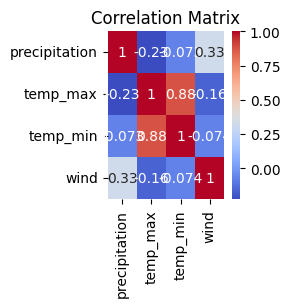

In [ ]:
plt.subplot(2, 3, 6)
numeric_cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

In [ ]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

NameError: name 'X_train_scaled' is not defined

In [ ]:
X = df.drop(["weather","date"], axis=1)
y = df["weather"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42)
}

In [ ]:
#Train and evaluate
best_model = None
best_acc = 0
results = [] # Initialize an empty list to store results

for name, clf in models.items():
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f" {name}")
    print(f"   Accuracy: {acc*100:.2f}%")
    print(f"   F1-score: {f1:.3f}")
    print(f"   Precision: {precision:.3f}")
    print(f"   Recall: {recall:.3f}")


    # Append results to the list
    results.append({"Model": name, "Accuracy (%)": acc * 100, "F1-score": f1, "Precision": precision, "Recall": recall})

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import numpy as np



# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 5, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.1, 1, 5, 10],
        'gamma': ['scale', 0.01, 0.001],
        'kernel': ['rbf']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.5, 1.0, 1.5]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 400],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 8],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
}


cv_folds = 5
n_jobs = -1

best_models = {}

for name, clf in models.items():
    print(f"Tuning hyperparameters for: {name}")

    if name not in param_grids:
        print(f"No hyperparameter grid provided for {name}, skipping.")
        continue

    param_grid = param_grids[name]


    grid = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv_folds,
        n_jobs=n_jobs,
        verbose=1
    )

    grid.fit(X_train_res, y_train_res)
    # Best estimator after tuning
    best_model = grid.best_estimator_
    best_models[name] = best_model


    y_pred = best_model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{name} — Test Accuracy: {acc:.4f}")
    print(f"{name} — Test Precision (weighted): {prec:.4f}")
    print(f"{name} — Test Recall (weighted): {rec:.4f}")
    print(f"{name} — Test F1-score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name} (Tuned)")
    plt.show()

print("\n Hyperparameter tuning complete for all models")


In [ ]:
results_df = pd.DataFrame(results).sort_values(by="Accuracy (%)", ascending=False)
print("\n Model Comparison Table:\n")
print(results_df)